# Evaluate performance of network

In [1]:
path = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FullSimCLD_240.root"

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['Events;1']
    data = tree.arrays(library="np")
    return data

In [4]:
data = load_data(path)

In [5]:
from sklearn.metrics import roc_curve, auc

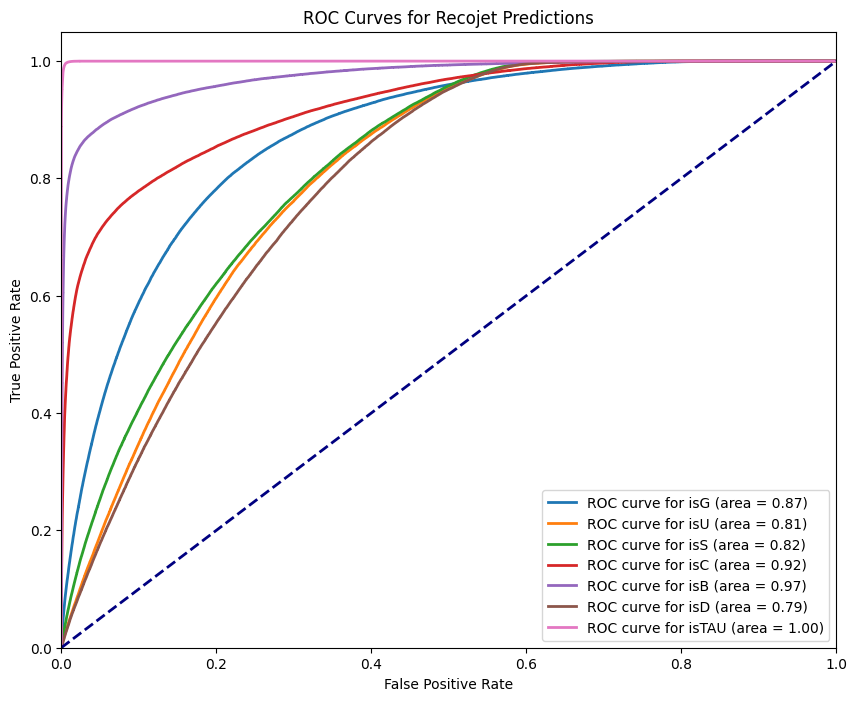

In [6]:
# Define a list of labels to iterate over
labels = ['G', 'U', 'S', 'C', 'B', 'D', 'TAU']

plt.figure(figsize=(10, 8))

# Loop through each label to compute and plot the ROC curve
for label in labels:
    true_labels = data[f'recojet_is{label}']
    scores = data[f'score_recojet_is{label}']

    # Filter out NaN values in true_labels and corresponding scores
    valid_indices = ~np.isnan(scores)
    true_labels_valid = true_labels[valid_indices]
    scores_valid = scores[valid_indices]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(true_labels_valid, scores_valid)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for is{label} (area = {roc_auc:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the axis labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Recojet Predictions')
plt.legend(loc="lower right")

# Show the plot
plt.show()

In [7]:
def invalid_ind():
    ind = []
    labels = ['G', 'U', 'S', 'C', 'B', 'D', 'TAU']
    for l in labels: 
        true_labels = data[f'recojet_is{l}']
        scores = data[f'score_recojet_is{l}']
        valid_indices = np.where(np.isnan(scores))
        ind.append(valid_indices)
    return np.unique(ind)

In [8]:
for d in data.keys():
    print(len(data[d]))

769930
769930
769930
769930
769930
769930
769930
769930
769930
769930
769930
769930
769930
769930


In [9]:


def calculate_efficiency_misid(true_labels, scores, invalid_indices):
    print("--------------------")
    print(len(true_labels))
    print(len(scores))
    print(len(invalid_indices))
    # Remove NaN values from true_labels and scores
    true_labels_valid = true_labels[valid_indices]
    scores_valid = scores[valid_indices]

    # Calculate ROC curve (true positive and false positive rates)
    fpr, tpr, thresholds = roc_curve(true_labels_valid, scores_valid)
    print(len(thresholds))
    
    # Target flavor efficiency (TPr)
    efficiency = tpr
    print(len(efficiency))
    
    # Misidentification rate (misid = FPr for non-target jets)
    misid = fpr
    print(len(misid))

    return efficiency, misid

def x_tagging_roc():
    invalid_indices = invalid_ind()
    # Efficiency and misidentification rates for b-tagging against c and light jets
    # Calculate efficiency for b-tagging
    eff_b, _ = calculate_efficiency_misid(data['recojet_isB'], data['score_recojet_isB'], invalid_indices)

    # Calculate misidentification rates for c-jets and light jets using b-tagging scores
    _, misid_c = calculate_efficiency_misid(data['recojet_isC'], data['score_recojet_isB'], invalid_indices)
    _, misid_s = calculate_efficiency_misid(data['recojet_isS'], data['score_recojet_isB'], invalid_indices)


    # Plot
    plt.figure(figsize=(8, 6))

    plt.plot(eff_b, misid_c, label='c misid vs b-tagging efficiency', lw=2, color='red')
    plt.plot(eff_b, misid_s, label='light misid vs b-tagging efficiency', lw=2, color='blue')

    # Axis labels and plot settings
    plt.xlabel('b-tagging efficiency')
    plt.ylabel('Misidentification probability')
    plt.title('Jet Misidentification vs b-tagging Efficiency')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.yscale('log')  # Commonly misidentification rates are shown in log scale

    # Show plot
    plt.show()



In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

In [11]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative

    number_positive = np.sum(mask_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative])

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]

        y_score_negative = y_score[mask_negative]
        indices = np.array([negative, positive])
        y_score_selected_positive = y_score_positive[:, indices]
        y_score_selected_negative = y_score_negative[:, indices]

        # Calculate probabilities using softmax
        y_scores_pos_prob = np.exp(y_score_selected_positive) / np.sum(
            np.exp(y_score_selected_positive), axis=1, keepdims=True
        )
        y_scores_neg_prob = np.exp(y_score_selected_negative) / np.sum(
            np.exp(y_score_selected_negative), axis=1, keepdims=True
        )

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1]
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        # Compute ROC curve and AUC score
        fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
        auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]
    else:
        return []

def log_multiline_rocs_b(y_true, y_score, labels, ax, k,j):
    q_tag = 4 # b-tagging
    vs_tag = [1,2, 5] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)


    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        # Calculate TPR for different ROC curves (this function needs to be defined elsewhere)
        #calculate_and_log_tpr_1_10_percent(_bg[0], _bg[1], "b", "g")
        #calculate_and_log_tpr_1_10_percent(_bud[0], _bud[1], "b", "ud")
        #calculate_and_log_tpr_1_10_percent(_bc[0], _bc[1], "b", "c")

        # Plot ROC curves
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            ax[k, j].plot(x, y, label=f"{labels[q_tag]} vs {labels[vs_tag[i]]}", color=dic_c[vs_tag[i]]) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k,j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k,j].grid()
        ax[k,j].set_ylim(-3, 0)
        ax[k,j].set_xlabel("jet tagging efficiency")
        ax[k,j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")



In [12]:
def log_multiline_rocs_c(y_true, y_score, labels, ax, k, j):
    q_tag = 2 # b-tagging
    vs_tag = [1,4, 5] # ud, b, g
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            ax[k, j].plot(x, y, label=f"{labels[q_tag]} vs {labels[vs_tag[i]]}", color=dic_c[vs_tag[i]]) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [13]:
def log_multiline_rocs_s(y_true, y_score, labels, ax, k, j):
    q_tag = 3 # s-tagging
    vs_tag = [1,2, 4, 5] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            ax[k, j].plot(x, y, label=f"{labels[q_tag]} vs {labels[vs_tag[i]]}", color=dic_c[vs_tag[i]]) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [14]:
def log_multiline_rocs_g(y_true, y_score, labels, ax, k, j):
    q_tag = 5 # g-tagging
    vs_tag = [1,2, 3, 4] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            ax[k, j].plot(x, y, label=f"{labels[q_tag]} vs {labels[vs_tag[i]]}", color=dic_c[vs_tag[i]]) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]} tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [15]:
def all_rocs(save=False):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(10, 4.5), constrained_layout=True)
    y_true, y_score = get_y_true_and_score()

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FullSimCLD240.pdf")
    plt.show()

In [16]:
def get_y_true_and_score():
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    y_true = np.array([data[f'recojet_is{label}'] for label in labels])
    y_true = np.argmax(y_true.T, axis=1)
    y_score = np.array([data[f'score_recojet_is{label}'] for label in labels])
    #print(y_score.shape)
    ind_nan = invalid_ind()
    #print(ind_nan.shape)
    y_score = np.delete(y_score, ind_nan, axis=1)
    y_true = np.delete(y_true, ind_nan)
    return y_true, y_score.T

In [17]:
from cycler import cycler

# Set the color cycle
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#D51A1A', '#ffad08', '#A882DD', '#D81E89'])) 

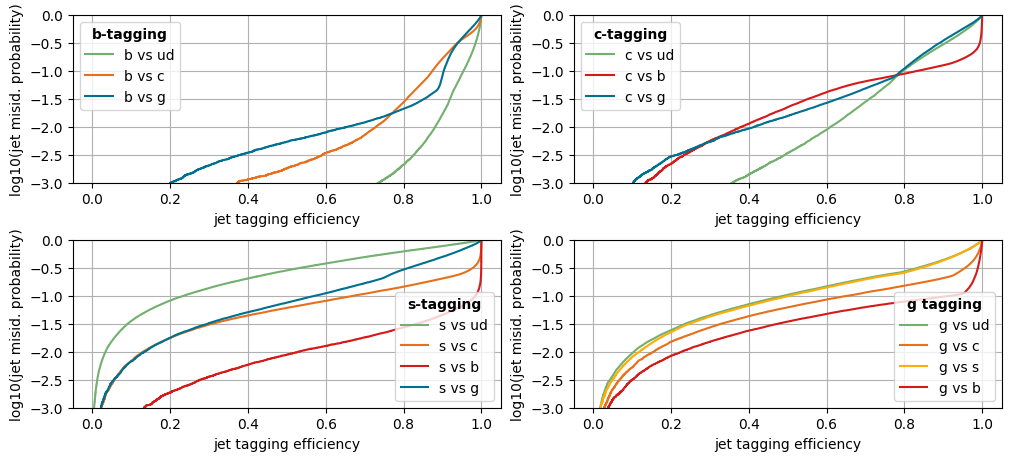

In [18]:
all_rocs(save=True)

# Confusion matrix

In [19]:
data

{'recojet_isG': array([False, False, False, ..., False, False, False]),
 'score_recojet_isG': array([0.03142653, 0.02337116, 0.00519975, ..., 0.08394387, 0.03360161,
        0.33369395], dtype=float32),
 'recojet_isU': array([False, False, False, ...,  True,  True,  True]),
 'score_recojet_isU': array([0.0003822 , 0.00138499, 0.00353506, ..., 0.2591175 , 0.3028197 ,
        0.22820327], dtype=float32),
 'recojet_isS': array([False, False, False, ..., False, False, False]),
 'score_recojet_isS': array([0.00057741, 0.00114795, 0.00376596, ..., 0.5230862 , 0.27698386,
        0.18845356], dtype=float32),
 'recojet_isC': array([False, False, False, ..., False, False, False]),
 'score_recojet_isC': array([0.00092031, 0.00114502, 0.01346399, ..., 0.0032575 , 0.08097626,
        0.04203431], dtype=float32),
 'recojet_isB': array([ True,  True,  True, ..., False, False, False]),
 'score_recojet_isB': array([0.9662031 , 0.9710305 , 0.9712762 , ..., 0.00282843, 0.00395945,
        0.0104757 ], d

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
# Convert scores to binary predictions based on a threshold of 0.5

def cov(data, save=False):
    labels = ['G', 'U', 'D', 'S', 'C', 'B', 'TAU']

    y_true = np.array([data[f'recojet_is{i}'] for i in labels]).T
    y_true = np.argmax(y_true, axis=1)

    y_score = np.array([data[f'score_recojet_is{j}'] for j in labels]).T
    y_pred = np.argmax(y_score, axis=1)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['g', 'u', 'd', 's', 'c', 'b', r'$\tau$'])
    disp.plot(cmap=plt.cm.Blues)

    # Show the plot
    plt.tight_layout()
    if save:
        plt.savefig("./plots-for-FCC-note/cm_fullSimCLD240.pdf")
    plt.show()

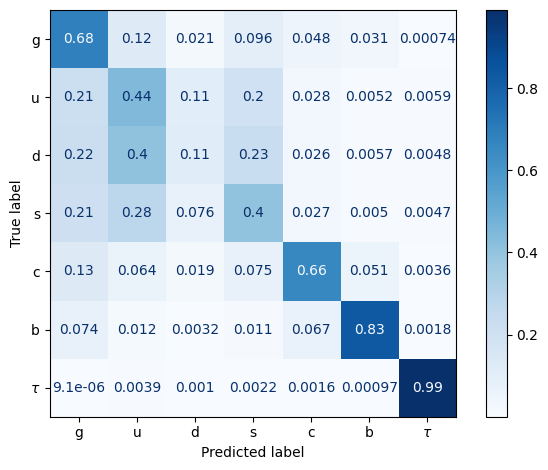

In [22]:
cov(data, False)